<a href="https://colab.research.google.com/github/Vaskisetkielet/learning-training/blob/main/Gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Импорт библиотек
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels as sm
import matplotlib.animation as animation
from IPython.display import HTML, display
from numpy.random import normal, seed, uniform

# Градиентный спуск

Градиентный спуск - вроде бы главный для ML способ нахождения оптимальных весов для моделей. Нужен он в связи с тем, что модель не знает, какие веса должны быть правильными, поэтому приходится их искать. Ниже представлена его реализация для простой линейной регрессии с объяснением всех шагов.

**TL;DR: внизу прикольные анимашки**

# Инициализация

Создадим набор линейно зависимых значений, где `х` - числа от 1 до 20, а `у` - результат функции $ax + b + шум$ и выведем график.

Text(0.5, 0, 'x')

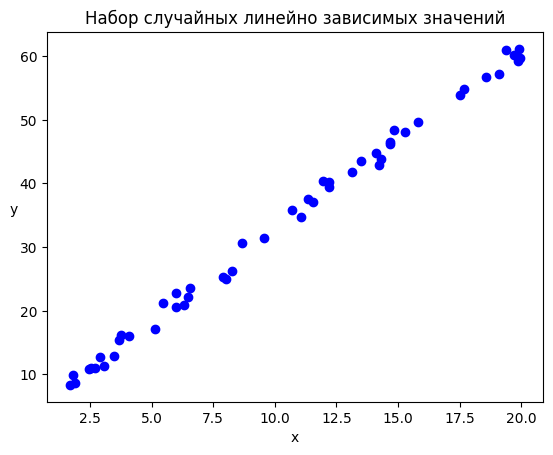

In [4]:
len_of_array = 50
noise = np.random.normal(0,1,len_of_array)
sign = random.choice([-1,1])
a0 = random.randint(-2,2) + random.random() * sign
b0 = random.randint(0,4) + random.random() * sign

x = np.random.uniform(1,20,len_of_array)
y = a0 * x + b0 + noise
fig, ax = plt.subplots()
plt.title("Набор случайных линейно зависимых значений")
plt.scatter(x,y, c='blue')
ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')

Теперь нормализуем `x` (т.е. приведем все значения к виду, где их среднее = 0, а стандартное отклонение = 1).

Делается это в связи с тем, что большие значения икса могут привести к очень большому шагу в сторону уменьшения ошибки при очередной итерации градиентного спуска, при котором в результате она (ошибка) может даже вырасти (перекинувшись на другую сторону, пример см. в конце).


In [5]:
scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()

Перенесем данные в табличный вид для наглядности

In [6]:
df = pd.DataFrame({'x': x, 'y_true': y})
df.head()

x     y_true
0  0.213143  37.062984
1 -0.681985  20.870498
2  0.680483  43.804657
3 -1.298346  10.933217
4 -1.437731   8.589976

# Первая итерация

В данный момент нам известны только значения `x` и `y`, но мы не знаем значения параметров функции `a` и `b`, связывающей их (на построенном выше графике мы видим, что между `х` и `у` существует линейная зависимость, т.е. мы можем описать её, построив прямую).

Попробуем построить прямую через начальные точки - инициализируем первичные значения для прогнозных параметров (наклон и сдвиг)


In [7]:
a = 0
b = df['y_true'].mean()

Сделаем прогноз и рассчитаем квадраты разниц между фактическим и прогнозным значениями.

Как видно из графика - здесь прогноз не меняется в зависимости от х, являясь статичным.

Также на графике представлен расчет функции ошибки (т.е. как мы измеряем соответствие прогноза фактическим данным). Для СреднеКвадратического Отклонения (далее - СКО) он выглядит как `(y-y прогнозный)^2`.



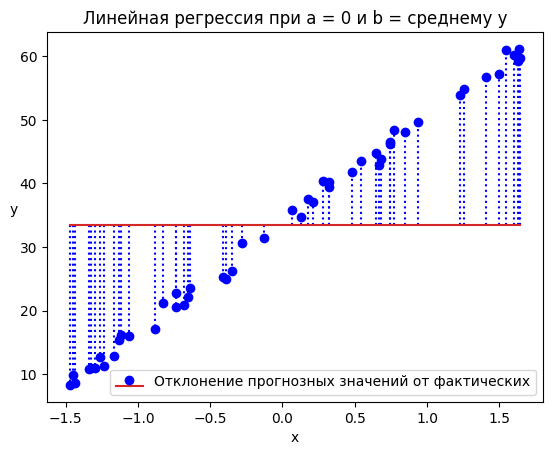

In [8]:
df['y_pred'] = a * df['x'] + b
df['MSE'] = (df['y_true'] - df['y_pred'])**2
fig, ax = plt.subplots()
ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')
plt.title('Линейная регрессия при a = 0 и b = среднему у')
ax.stem(df['x'], df['y_true'], linefmt ='b:', bottom = df['y_pred'].mean(), label='Отклонение прогнозных значений от фактических')
#plt.scatter(df['x'], df['y_true'])
#plt.plot(df['x'], df['y_pred'], c='r')
plt.legend(loc='lower right')

Рассчитаем СКО для первой итерации - сначала находится попарно разница между фактическим и прогнозным у, после чего получившиеся значения возводятся в квадрат, и, наконец, рассчитывается их среднее значение.


In [9]:
# Текущее СКО
MSE_1 = df['MSE'].mean()
print(f'Среднеквадратическое отклонение равно {MSE_1:.4f}')

Среднеквадратическое отклонение равно 283.0721


Т.е. **в среднем** квадрат разниц между фактическим и прогнозным значением такой.

#Начинаем градиентный спуск

Теперь, для того, чтобы приблизить прогноз к фактическим данным, нам требуется минимизировать функцию потерь - сделать это можно с помощью градиента (градиент обычно описывается как величина, показывающая направление наискорейшего роста функции нескольких переменных, но для целей обучения можно дать альтернативное и более простое определение - совокупность всех частных производных функции), поэтому название метода - градиентный спуск (спуск к минимально возможной разнице между прогнозными и фактическими значениями).

Находим градиент функции потерь, т.к. требуется минимизировать именно её (в данном случае для СКО - градиент это её производные по `a` и `b`).

Так как прогнозный `y` (`ŷ`) является формулой $ax+b$, то $(y-ŷ)^2 = (y-(ax+b))^2 = (y-ax-b)^2$; ниже указаны частные производные этой функции.

$d/da((y-ax-b)^2) = -2x*(y - ax - b)$

$d/db((y-ax-b)^2) = -2*(y - ax - b)$

Как можно заметить, последний множитель в обеих производных равен `y-ŷ` (`ŷ` заменяем на `ax+b`).

## Learning rate

Теперь установим темп обучения (обозначается буквой ню или просто как learning rate, самые частые для образовательных целей - 0.05 и 0.1) и применим выведенные выше формулы для нахождения скорости изменения функции в конкретных точках.

Learning rate определяет, насколько широким будет наш шаг в правильную сторону.

- При оптимальном значении LR мы смелыми шагами движемся в сторону оптимального набора параметров.
- Если LR слишком большой, то мы перепрыгиваем через правильную сторону (*можно сравнить с ситуацией, когда нам надо находясь на окружности прыгнуть в сторону её центра, но прыжок слишком большой и мы перепрыгиваем этот центр, оказываясь на другой стороне*). Таким образом, если LR выше оптимального - спуск либо зацикливается, перепрыгивая через корректное значение, либо улетает в космос, если LR ещё выше (т.е. оптимальные значения в обоих случаях не находятся).
- Если LR слишком маленький - может значительно увеличиться время расчета и требуемые ресурсы, плюс мы можем не найти оптимальное значение за указанное число шагов.

In [10]:
nu = 0.1
df['a_change'] = -2 * df['x'] * (df['y_true'] - df['y_pred'])
df['b_change'] = -2 *           (df['y_true'] - df['y_pred'])

Обновим значения `a` и `b` - ниже мы вычитаем, поскольку градиент указывает направление наискорейшего роста функции, таким образом, для минимизации ошибки нужно идти в обратную сторону (т.е. в сторону *антиградиента*).

Для удобства можно поменять знак при расчете _change столбцов, убрав минус перед двойкой, тогда здесь будет плюс.


In [11]:
a = a - nu * df['a_change'].mean()
b = b - nu * df['b_change'].mean()

Сделаем обновленный прогноз со скорректированными весами, посчитаем для него СКО и сравним с первым значением:


In [12]:
df['y_pred_2'] = a * df['x'] + b
df['MSE_2'] = (df['y_true'] - df['y_pred_2'])**2

MSE_2 = df['MSE_2'].mean()
print(f'СКО для первого набора параметров: {MSE_1:.2f}, \nСКО для второго набора параметров: {MSE_2:.2f}')

СКО для первого набора параметров: 283.07, 
СКО для второго набора параметров: 181.59


Как можно увидеть, значение функции потерь (СКО) уменьшилось - то есть уменьшилась средняя разница между прогнозными и фактическими значениями. Посмотрим, как это выглядит на графике.

Text(0.5, 24.0, 'x')

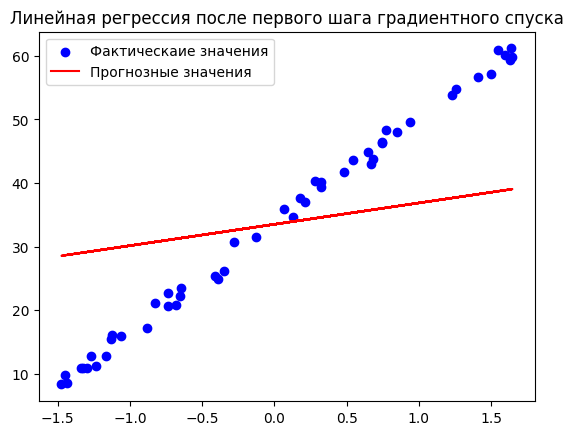

In [13]:
# Построим график обновленного прогноза: как из него можно увидеть, линия стала ближе к корректной репрезентации точек.
plt.title('Линейная регрессия после первого шага градиентного спуска')
plt.scatter(df['x'], df['y_true'], c='blue')
plt.plot(df['x'], df['y_pred_2'], c='red')
plt.legend(['Фактические значения','Прогнозные значения'])
ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')

Линия, представляющая собой прогнозные значения, сдвинулась в нужном нам направлении, но это был только первый шаг. Для того, чтобы функция максимально близко соответствовала данным, нам потребуется значительно больше шагов.

# Полноценный градиентный спуск

Теперь попробуем более быстрый метод, при котором пройдет 50 итераций спуска.

Ниже представлены результаты 50 итераций.


In [14]:
# Теперь попробуем более быстрый метод, при котором пройдет 50 итераций спуска.
len_of_array = 50
noise = np.random.normal(0,2,len_of_array)
sign = random.choice([-1,1])
a0 = random.randint(-2,2) + random.random() * sign
b0 = random.randint(0,4) + random.random() * sign
x = np.random.uniform(1,20,len_of_array)
y = a0 * x + b0 + noise

scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()

df = pd.DataFrame({'x': x, 'y_true': y})

a = 0
b = df['y_true'].mean()
nu = 0.1

df['y_pred'] = a * df['x'] + b

for i in range(51):
  df['a_change'] = -2 * df['x'] * (df['y_true'] - df['y_pred'])
  df['b_change'] = -2 * (df['y_true'] - df['y_pred'])
  a = a - nu * df['a_change'].mean()
  b = b - nu * df['b_change'].mean()
  df['y_pred'] = df['x'] * a + b
  df['MSE'] = (df['y_true'] - df['y_pred'])**2
  if i%5==0:
    print(f'Для итерации {i} СКО равно {df["MSE"].mean():.4f}')
print(f'Итоговый приближенный наклон равен {a:.3f}, сдвиг равен {b:.3f}')

Для итерации 0 СКО равно 36.3906
Для итерации 5 СКО равно 7.1064
Для итерации 10 СКО равно 3.9621
Для итерации 15 СКО равно 3.6244
Для итерации 20 СКО равно 3.5882
Для итерации 25 СКО равно 3.5843
Для итерации 30 СКО равно 3.5839
Для итерации 35 СКО равно 3.5838
Для итерации 40 СКО равно 3.5838
Для итерации 45 СКО равно 3.5838
Для итерации 50 СКО равно 3.5838
Итоговый приближенный наклон равен 7.160, сдвиг равен 17.544


 Для примера, сравнение с линейной регрессией sklearn-a:

In [15]:
from sklearn.linear_model import LinearRegression
x=x.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(x, y)
y_pred = linreg.predict(x)
print(f'Итоговый расчетный наклон равен {linreg.coef_[0]:.3f}, сдвиг равен {linreg.intercept_:.3f}')

Итоговый расчетный наклон равен 7.160, сдвиг равен 17.544


Как можно увидеть, значения максимально близки друг к другу.

# Анимированная версия градиентного спуска на линейной регрессии

Ниже представлена анимация 25 шагов градиентнго спуска. Для проигрывания нужно нажать ➤

In [16]:
len_of_array = 50
noise = np.random.normal(0,2,len_of_array)
sign = random.choice([-1,1])
a0 = random.randint(-2,2) + random.random() * sign
b0 = random.randint(0,4) + random.random() * sign
x = np.random.uniform(1,20,len_of_array)
y = a0 * x + b0 + noise

scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()

df = pd.DataFrame({'x': x, 'y_true': y})

a = 0
b = df['y_true'].mean()
nu = 0.1

df['y_pred'] = a * df['x'] + b
df['MSE'] = (df['y_true'] - df['y_pred'])**2

fig, ax = plt.subplots()

scatter = ax.scatter(df['x'],df['y_true'],c='b')
line = ax.plot(df['x'], df['y_pred'],c='r')[0]
counter=0
ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')


def update(frame):
  global a,b,counter
  if frame==0 and counter==0:
    plt.title('Градиентный спуск для линейной регрессии')
    ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'])
    counter+=1
    return None
  plt.title('Градиентный спуск для линейной регрессии')
  line.set_xdata(df['x'])
  line.set_ydata(df['y_pred'])
  ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'])
  df['a_change'] = -2 * df['x'] * (df['y_true'] - df['y_pred'])
  df['b_change'] = -2 * (df['y_true'] - df['y_pred'])
  a = a - nu * df['a_change'].mean()
  b = b - nu * df['b_change'].mean()
  df['y_pred'] = df['x'] * a + b
  df['MSE'] = (df['y_true'] - df['y_pred'])**2
  # update the line plot:
  return (line)

ani = animation.FuncAnimation(fig=fig, func=update, frames=25, interval=200)
from IPython.display import HTML, display
display(HTML(ani.to_jshtml()))
plt.close(fig)

# После нахождения минимального значения следует развернуть скейлер обратно

При построении прогнозов не следует забывать о том, что значения х являются нормализованными, то есть модифицированными.

# Анимированная версия градиентного спуска для нелинейной регрессии

Попробуем что-то сложнее: добавим ещё одну переменную и сделаем функцию квадратической.

In [17]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x, mult)) + noise(x,add)
x = np.linspace(-3,3,num=27)
y = add_noise(((3*x)**2+2*x+1), 0.3, 1.5)
scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()

df = pd.DataFrame({'x': x, 'y_true': y})

a = 1
b = 1
c = 1
nu = 0.01

ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')

df['y_pred'] = (a * df['x'])**2 + b * df['x'] + c
df['MSE'] = (df['y_true'] - df['y_pred'])**2

fig, ax = plt.subplots()

scatter = ax.scatter(df['x'],df['y_true'],c='b')
line = ax.plot(df['x'], df['y_pred'],c='r')[0]
counter=0

def update(frame):
  global a,b,c,counter
  if frame==0 and counter==0:
    plt.title('Градиентный спуск для нелинейной регрессии (nu=0.01)')
    ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'])
    counter+=1
    return None
  plt.title('Градиентный спуск для нелинейной регрессии (nu=0.01)')
  line.set_xdata(df['x'])
  line.set_ydata(df['y_pred'])
  ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'],loc='upper center')

  df['a_change'] = -2 * df['x']**2 * (df['y_true'] - df['y_pred'])
  df['b_change'] = -2 * df['x'] *     (df['y_true'] - df['y_pred'])
  df['с_change'] = -2 *               (df['y_true'] - df['y_pred'])

  a = a - nu * df['a_change'].mean()
  b = b - nu * df['b_change'].mean()
  с = b - nu * df['b_change'].mean()
  df['y_pred'] = (a * df['x'])**2 + b * df['x'] + c
  df['MSE'] = (df['y_true'] - df['y_pred'])**2
  return (line)

ani = animation.FuncAnimation(fig=fig, func=update, frames=50, interval=200)
from IPython.display import HTML, display
display(HTML(ani.to_jshtml()))
plt.close(fig)

In [19]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x, mult)) + noise(x,add)
x = np.linspace(-3,3,num=27)
y = add_noise(((3*x)**2+2*x+1), 0.3, 1.5)
scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()

df = pd.DataFrame({'x': x, 'y_true': y})

a = 1
b = 1
c = 1
nu = 0.06

ax.set_ylabel('y',rotation=0)
ax.set_xlabel('x')

df['y_pred'] = (a * df['x'])**2 + b * df['x'] + c
df['MSE'] = (df['y_true'] - df['y_pred'])**2

fig, ax = plt.subplots()

scatter = ax.scatter(df['x'],df['y_true'],c='b')
line = ax.plot(df['x'], df['y_pred'],c='r')[0]
counter=0

def update(frame):
  global a,b,c,counter
  if frame==0 and counter==0:
    plt.title(f'Градиентный спуск для нелинейной регрессии (nu={nu})')
    ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'])
    counter+=1
    return None
  plt.title(f'Градиентный спуск для нелинейной регрессии (nu={nu})')
  line.set_xdata(df['x'])
  line.set_ydata(df['y_pred'])
  ax.legend([f'Шаг #{frame}',f'СКО = {df["MSE"].mean():.4f}'], loc='upper center')

  df['a_change'] = -2 * df['x']**2 * (df['y_true'] - df['y_pred'])
  df['b_change'] = -2 * df['x'] *     (df['y_true'] - df['y_pred'])
  df['с_change'] = -2 *               (df['y_true'] - df['y_pred'])

  a = a - nu * df['a_change'].mean()
  b = b - nu * df['b_change'].mean()
  с = b - nu * df['b_change'].mean()
  df['y_pred'] = (a * df['x'])**2 + b * df['x'] + c
  df['MSE'] = (df['y_true'] - df['y_pred'])**2
  return (line)

ani = animation.FuncAnimation(fig=fig, func=update, frames=50, interval=200)
from IPython.display import HTML, display
display(HTML(ani.to_jshtml()))
plt.close(fig)

# При построении прогнозов не следует забывать о том, что значения х являются нормализованными.

В качестве примера почему правильный learning rate важен при градиентном спуске - выше представлена та же функция, но с learning rate-ом равным 0.06 (на предыдущей анимации он равен 0.01).

Также при построении прогнозов не следует забывать, что значения являются нормализованными.
